In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd

import h5py
import scipy.io as io
from PIL import Image
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
# from model import CSRNet
import torch
%matplotlib inline

from model import CSRNet

C:\Users\jthe\AppData\Local\Temp\ipykernel_19708\3863198652.py:11: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
# this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

#     pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
root = 'D:/Dev/project/roofcounting/'

In [4]:
label = os.path.join(root, "data/train_data/images")        
labelled_paths = []
for path in glob.glob(os.path.join(label, "*.png")):
    labelled_paths.append(path)

In [5]:
for label_file in labelled_paths: 
#     print(label_file)
    img = plt.imread(label_file)
    gt = pd.read_csv(label_file.replace(".png", ".csv"))

    #     gt = gt.to_numpy()
    # need to remove index
    gt = gt[['x','y']].to_numpy()

    k = np.zeros((img.shape[0], img.shape[1]))
    for i in range(0, len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1
    k = gaussian_filter_density(k)  
    with h5py.File(label_file.replace('.png','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k 

(1056, 816)
generate density...


C:\Users\jthe\AppData\Local\Temp\ipykernel_19708\1350554050.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
(1056, 816)
generate density...


C:\Users\jthe\AppData\Local\Temp\ipykernel_19708\1350554050.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.


D:/Dev/project/roofcounting/data/train_data/images\Image_1.png


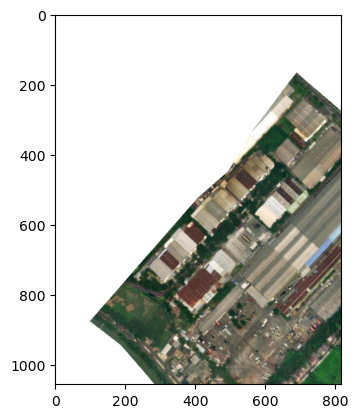

In [6]:
sanitycheck_path = labelled_paths[0]
print(sanitycheck_path)
plt.imshow(Image.open(sanitycheck_path))

24.779049


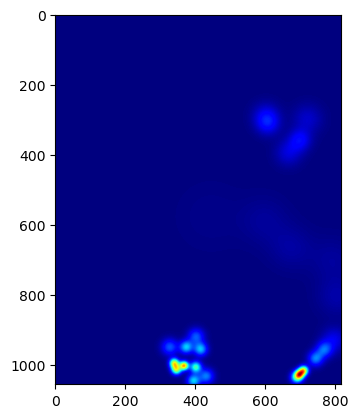

In [7]:
gt_file = h5py.File(sanitycheck_path.replace('.png','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
# don't mind this slight variation
print(np.sum(groundtruth))

343.17447